# 분석4 : CLI by CKD 에 따른 lab data 

## TOC
* [전체 데이터 살펴보기](#전체-데이터-탐색)
* [Demographic Data](#Demographic-data)
    * [Demo Data 탐색](#빠른-Demo-data-탐색)
    * [Demo Data 검정](#Demographic-차이-검정)

* [Lab Data](#Lab-data)
    * [Lab Data 탐색](#Lab-data-탐색)
    * [Lab Data 검정](#Lab-data-검정)
        * [결과](#Lab-결과)
    * [교란변수 고정](#교란변수-고정)
        * [결과](#고정-결과)

* [Logistic regression](#로지스틱-회귀)
    * [회귀 결과](#회귀-결과)



#### 4) 분석 4 

같은 CKD stage 지만 CLI 유무에 따라 lab data  (Average CFU, VEGF, VEGF/CD34, CD34, SDF-1, VEGF) 의 차이를 보는 것이 분석 4 입니다.
- Group 3 vs Group 6
- Group 4 vs Group 7
- Group 5 vs Group 8 

## 분석 4

### CLI by CKD 의 자료 분석

In [20]:
#데이터 불러오기
library(xlsx)
library(dplyr)

data <- read.xlsx("../EPCinCKD_201802.xlsx", sheetIndex = 1)
data <- data[1:150,-c(1,2)]
colnames(data)[c(7, 13, 15, 16, 22)] <- c("HTN", "statin", "obesity", "PAD", "CD34.All")
data <- data %>% mutate( CLI = as.numeric(Group>5))
data <- data[complete.cases(data),]
dim(data)

[1] 133  25

In [24]:
## CKD 변수 추가
data <- data %>% mutate(CKD = CKD.class-2)
summary(as.factor(data$CKD))

1  2  3 
52 40 41

---
# 전체 데이터 탐색
---

CLI 및 CKD 로 나눈 집단의 

Demographic data 및

Average CFU, VEGF, VEGF/CD34, CD34, SDF-1, VEGF 수치를 확인하자 


### 상관계수 


<상관관계 Heat map>


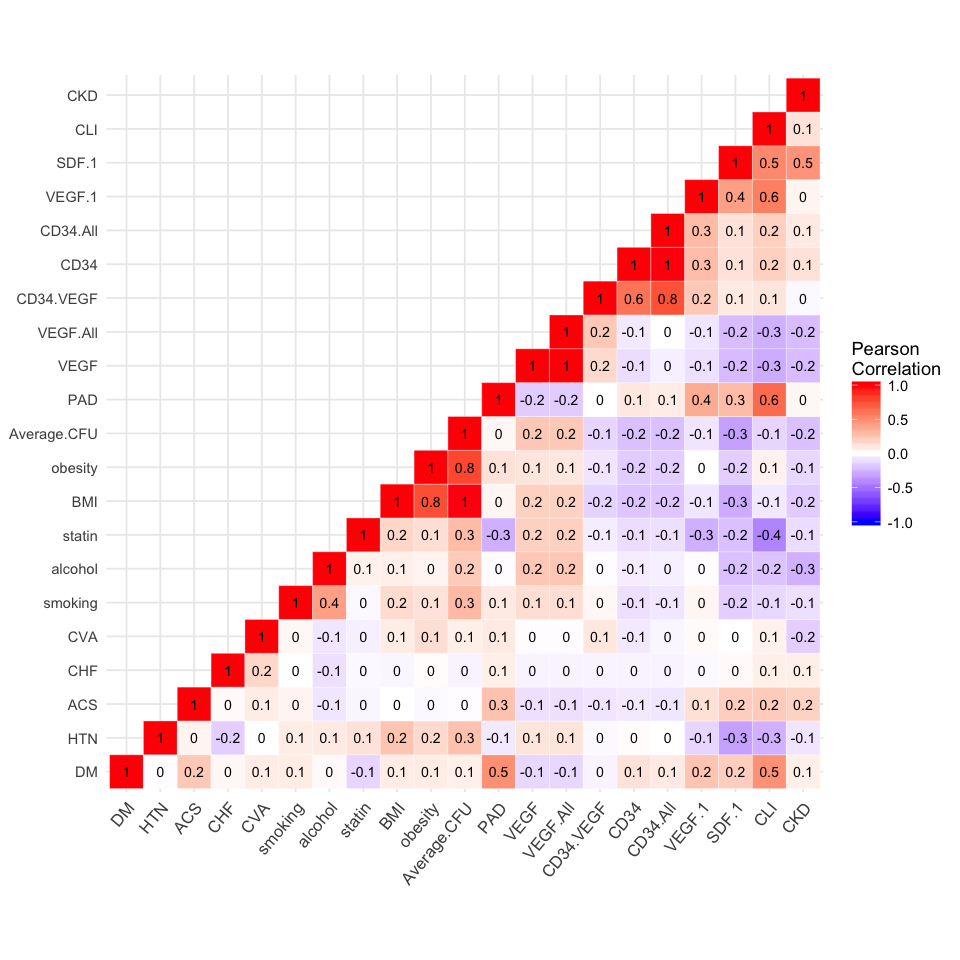

In [99]:
# 상관 계수를 살펴보자 
library(ggplot2)
library(gridExtra)
library(reshape2)

cormat <- round(cor(data[c(6:13,14, 15,17,16, 18,21, 19, 20 ,22, 23, 24,25,26)], use = 'complete.obs'),2)
cormat[lower.tri(cormat)]<- NA

cat("\n<상관관계 Heat map>\n")

melted_cormat <- melt(cormat, na.rm = TRUE)

options(repr.plot.width=8, repr.plot.height=8)
ggplot(data = melted_cormat, aes(Var2, Var1, fill = value))+
    geom_tile(color = "white")+
    scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
                         midpoint = 0, limit = c(-1,1), space = "Lab", 
                         name="Pearson\nCorrelation") +
    theme_minimal()+ 
    theme(axis.text.x = element_text(angle = 50, vjust = 1, 
                                     size = 10, hjust = 1) , 
          axis.title.x=element_blank(), 
          axis.title.y=element_blank())+
    coord_fixed() + geom_text(aes(Var2, Var1, label = round(value,1)), color = "black", size = 3)

대략적으로 느껴지는 것은 

CKD 와 CLI 가 굉장히 비슷하고, 

차이가 나는 곳이 VEGF.1 과 PAD 정도 인 것으로 보인다. 

따라서 대부분의 지표의 효과가 CKD 로 설명될 것으로 생각된다. 

---
# Demographic data
---

## 빠른 Demo data 탐색

In [26]:
library(dplyr)
data %>% 
    mutate(CLI = as.factor(CLI), CKD=as.factor(CKD)) %>% 
    group_by(CKD, CLI) %>% 
    summarise( n=length(CLI) )

CKD,CLI,n
1,0,41
1,1,11
2,0,33
2,1,7
3,0,27
3,1,14



CLI(group6+7+8) number :  32 /  133 


<CLI 그룹에 따른 Demographic data 비교>


CKD,CLI,gender.ratio,mean.Age,DM.ratio,HTN.ratio,ACS.ratio,CHF.ratio,CVA.ratio,smoking.ratio,alcohol.ratio,statin.ratio,mean.BMI,obesity.ratio,PAD.ratio
1,0,0.63,64.06,0.39,0.93,0.12,0.02,0.22,0.54,0.39,0.59,24.22,0.39,0.29
1,1,0.82,66.36,0.91,0.82,0.09,0.09,0.18,0.27,0.09,0.00,24.77,0.64,1.00
2,0,0.42,65.03,0.39,0.94,0.09,0.00,0.03,0.30,0.21,0.64,24.36,0.42,0.24
2,1,0.86,71.57,0.86,0.57,0.14,0.00,0.00,0.43,0.14,0.14,22.66,0.29,1.00
3,0,0.44,58.31,0.37,0.89,0.15,0.07,0.04,0.44,0.11,0.44,23.00,0.26,0.22
3,1,0.64,65.43,1.00,0.71,0.57,0.07,0.21,0.21,0.00,0.07,22.58,0.36,1.00




<CLI 그룹에 따른 Demographic data 시각화>

   CLI 0 = 빨강


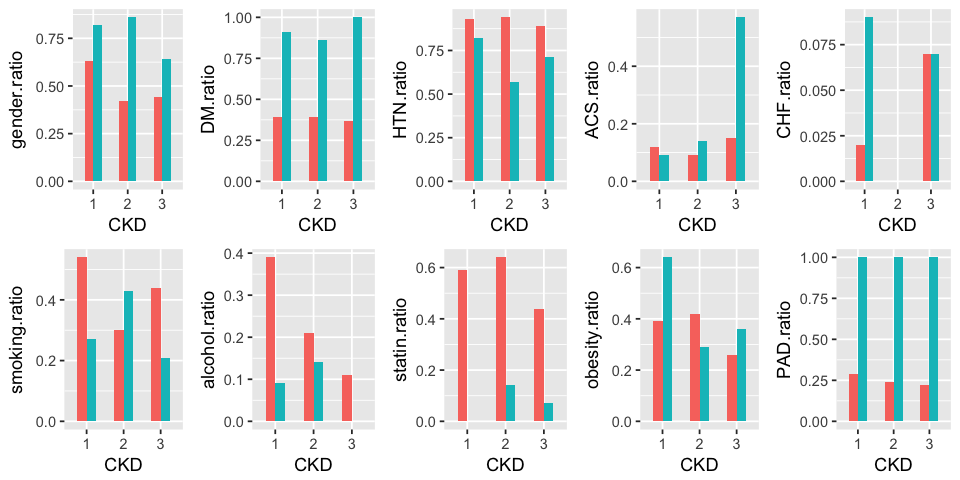

In [64]:
# CLI 데이터 수 
cat( "\nCLI(group6+7+8) number : ", sum(data$CLI), "/ ", length(data$CLI),"\n")

library(dplyr)
library(ggplot2)

# Demographic data
cat("\n\n<CLI 그룹에 따른 Demographic data 비교>\n")
demo.data <- data %>% 
    mutate(CKD = as.factor(CKD)) %>% 
    group_by( CKD, CLI ) %>%
    summarise( gender.ratio = mean(Gender, na.rm = T),
            mean.Age = mean(Age, na.rm = T),
            DM.ratio = mean(DM, na.rm = T),
            HTN.ratio = mean(HTN, na.rm = T),
            ACS.ratio = mean(ACS, na.rm = T),
            CHF.ratio = mean(CHF, na.rm = T),
            CVA.ratio = mean(CVA, na.rm = T),
            smoking.ratio = mean(smoking, na.rm = T),
            alcohol.ratio = mean(alcohol, na.rm = T),
            statin.ratio = mean(statin, na.rm = T),
            mean.BMI = mean(BMI, na.rm = T),
            obesity.ratio = mean(obesity, na.rm = T),
            PAD.ratio = mean(PAD, na.rm = T)
             ) %>%
    mutate_if(is.numeric, funs(round(., 2)))

demo.data

library(gridExtra)
library(repr)
plots <- list()  # new empty list

for (key in c("gender.ratio", "DM.ratio", "HTN.ratio", "ACS.ratio","CHF.ratio","smoking.ratio","alcohol.ratio","statin.ratio", "obesity.ratio", "PAD.ratio")) {
    p1 <- demo.data %>% mutate(CLI = as.factor(CLI)) %>% 
        ggplot(aes_string(x="CKD", y=key, fill="CLI")) +
        geom_bar(stat="identity", position="dodge", width=0.5) +
        scale_x_discrete("CKD", breaks= c(1,2,3), labels=c("1","2","3"))+ 
        guides(fill=FALSE)
    plots[[key]] <- p1  # add each plot into plot list
}

options(repr.plot.width=8, repr.plot.height=4)
cat("\n\n<CLI 그룹에 따른 Demographic data 시각화>\n")
cat("\n   CLI 0 = 빨강\n")
grid.arrange(grobs=plots, ncol=5)

일부 도수가 없는 부분이 존재함을 알 수 있다. 

CHF, alcohol, statin

이런 부분은 유의성 차이를 보기 어려울 것 



<Age, BMI 분포 그래프>
   CLI 0 = 빨강


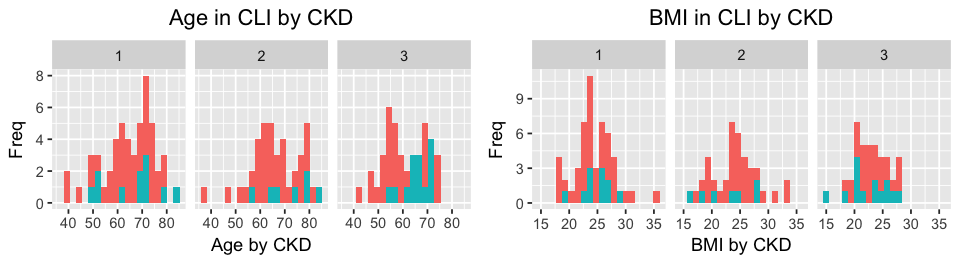

In [87]:
# 각각의 값에 대한 그래프 그리기
library(ggplot2)
library(gridExtra)

p1 <- data %>% mutate(CLI=as.factor(CLI), CKD = as.factor(CKD)) %>% 
    ggplot(aes(x=Age, fill=CLI)) +
    geom_histogram(bins=20, na.rm = T) +  
    ggtitle("Age in CLI by CKD") +
    labs(x="Age by CKD", y="Freq") +
    theme(plot.title = element_text(hjust = 0.5)) +
    facet_wrap(~CKD) + 
    guides(fill=FALSE)

p2 <- data %>% mutate(CLI=as.factor(CLI), CKD = as.factor(CKD)) %>% 
    ggplot(aes(x=BMI, fill=CLI)) +
    geom_histogram(bins=20, na.rm = T) +  
    ggtitle("BMI in CLI by CKD") +
    labs(x="BMI by CKD", y="Freq") +
    theme(plot.title = element_text(hjust = 0.5)) +
    facet_wrap(~CKD) + 
    guides(fill=FALSE)

cat("\n\n<Age, BMI 분포 그래프>")
cat("\n   CLI 0 = 빨강\n")
options(repr.plot.width=8, repr.plot.height=2.2)
grid.arrange(p1, p2, ncol=2)

큰 차이는 없어보이지만, 분포를 확인하기에는 CLI = 1 인 집단이 너무 적은 것으로 생각된다. 

## Demographic 차이 검정

#### 범주형 변수 

In [73]:
# "Gender", "DM", "HTN", "ACS",  "CVA", "smoking", "obesity"
# Chisq test for tabular data => 도수가 적어서 fisher's exact test
for(i in 1:3){
    tmp <- data %>% filter(CKD ==i) 
    
    cat("\n\n< CKD =",i, ">")
    for(key in c("Gender", "DM", "HTN", "ACS",  "CVA", "smoking", "obesity")){
        test <- fisher.test(tmp[key][,1], tmp["CLI"][,1])
        cat("\n", key, "result : p-value =", round(test$p.value, 3))
    }
}




< CKD = 1 >
 Gender result : p-value = 0.304
 DM result : p-value = 0.005
 HTN result : p-value = 0.283
 ACS result : p-value = 1
 CVA result : p-value = 1
 smoking result : p-value = 0.177
 obesity result : p-value = 0.182

< CKD = 2 >
 Gender result : p-value = 0.091
 DM result : p-value = 0.04
 HTN result : p-value = 0.03
 ACS result : p-value = 0.552
 CVA result : p-value = 1
 smoking result : p-value = 0.662
 obesity result : p-value = 0.681

< CKD = 3 >
 Gender result : p-value = 0.326
 DM result : p-value = 0
 HTN result : p-value = 0.205
 ACS result : p-value = 0.01
 CVA result : p-value = 0.107
 smoking result : p-value = 0.186
 obesity result : p-value = 0.719

In [93]:
# CHF, alcohol, statin 13 12 23

for(i in 1:3){
    tmp <- data %>% filter(CKD ==i) 
    keys <- c("statin", "CHF", "alcohol")
    cat("\n\n< CKD =",i, ">")
    for(key in keys[-i]){
        test <- fisher.test(tmp[key][,1], tmp["CLI"][,1])
        cat("\n", key, "result : p-value =", round(test$p.value, 3))
    }
}



< CKD = 1 >
 CHF result : p-value = 0.382
 alcohol result : p-value = 0.078

< CKD = 2 >
 statin result : p-value = 0.033
 alcohol result : p-value = 1

< CKD = 3 >
 statin result : p-value = 0.031
 CHF result : p-value = 1

**DM, HTN, ACS, statin** 정도가 유의미할때가 있다. 

#### 연속형 변수 

In [97]:
# Chisq test for tabular data
for(i in 1:3){
    tmp <- data %>% filter(CKD ==i) 
    
    cat("\n\n< CKD =",i, ">")
    for(key in c("Age","BMI")){
        test <- t.test(tmp[key][,1], tmp["CLI"][,1]) #wilcox test 도 마찬가지 결과 
        cat("\n", key, "result : p-value =", round(test$p.value, 3))
    }
}



< CKD = 1 >
 Age result : p-value = 0
 BMI result : p-value = 0

< CKD = 2 >
 Age result : p-value = 0
 BMI result : p-value = 0

< CKD = 3 >
 Age result : p-value = 0
 BMI result : p-value = 0

---
# Lab data
---


## Lab data 탐색

In [28]:
# CLI 그룹별 비교

cat("\n<CLI 그룹에 따른 Lab data 비교>\n")
cat("\n<평균>\n")
data %>% 
    group_by( CKD, CLI ) %>% 
    summarise( mean.Average.CFU = mean(Average.CFU, na.rm = T),
            mean.VEGF = mean(VEGF, na.rm = T),
            mean.CD34.VEGF = mean(CD34.VEGF, na.rm=T),
            mean.CD34 = mean(CD34, na.rm = T),
            mean.VEGF.All = mean(VEGF.All, na.rm = T),
            mean.CD34.All = mean(CD34.All, na.rm = T),
            mean.VEGF.1 = mean(VEGF.1, na.rm = T),
            mean.SDF.1 = mean(SDF.1, na.rm = T)
             ) %>%
    mutate_if(is.numeric, funs(round(., 2)))


cat("\n<표준편차>\n")
data %>% 
    group_by( CKD, CLI ) %>%
    summarise( std.Average.CFU = sqrt(var(Average.CFU, na.rm = T)),
            std.VEGF = sqrt(var(VEGF, na.rm = T)),
            std.CD34.VEGF = sqrt(var(CD34.VEGF, na.rm=T)),
            std.CD34 = sqrt(var(CD34, na.rm = T)),
            std.VEGF.All = sqrt(var(VEGF.All, na.rm = T)),
            std.CD34.All = sqrt(var(CD34.All, na.rm = T)),
            std.VEGF.1 = sqrt(var(VEGF.1, na.rm = T)),
            std.SDF.1 = sqrt(var(SDF.1, na.rm = T))
             ) %>%
    mutate_if(is.numeric, funs(round(., 2)))


<CLI 그룹에 따른 Lab data 비교>

<평균>


CKD,CLI,mean.Average.CFU,mean.VEGF,mean.CD34.VEGF,mean.CD34,mean.VEGF.All,mean.CD34.All,mean.VEGF.1,mean.SDF.1
1,0,5.22,6.43,0.30,0.12,6.73,0.42,63.51,2201.84
1,1,5.15,3.86,0.37,0.33,4.23,0.70,202.03,2772.89
2,0,5.19,7.12,0.33,0.10,7.45,0.43,67.30,2619.55
2,1,4.73,5.39,0.34,0.64,5.73,0.98,85.65,3688.43
3,0,4.85,4.35,0.25,0.25,4.59,0.50,51.14,2880.37
3,1,4.64,1.09,0.41,0.87,1.50,1.28,213.09,4084.00



<표준편차>


CKD,CLI,std.Average.CFU,std.VEGF,std.CD34.VEGF,std.CD34,std.VEGF.All,std.CD34.All,std.VEGF.1,std.SDF.1
1,0,0.89,3.89,0.25,0.36,3.97,0.41,46.61,508.18
1,1,0.62,2.62,0.30,0.69,2.77,0.84,126.97,829.03
2,0,0.85,4.44,0.29,0.17,4.52,0.42,52.41,441.34
2,1,1.11,12.06,0.27,1.25,12.15,1.39,86.77,999.87
3,0,0.72,3.55,0.20,0.74,3.59,0.79,33.55,593.45
3,1,0.78,1.06,0.67,2.74,1.39,3.39,158.14,1159.80




<CLI 그룹에 따른 Demographic data 시각화>

   CLI 0 = 빨강


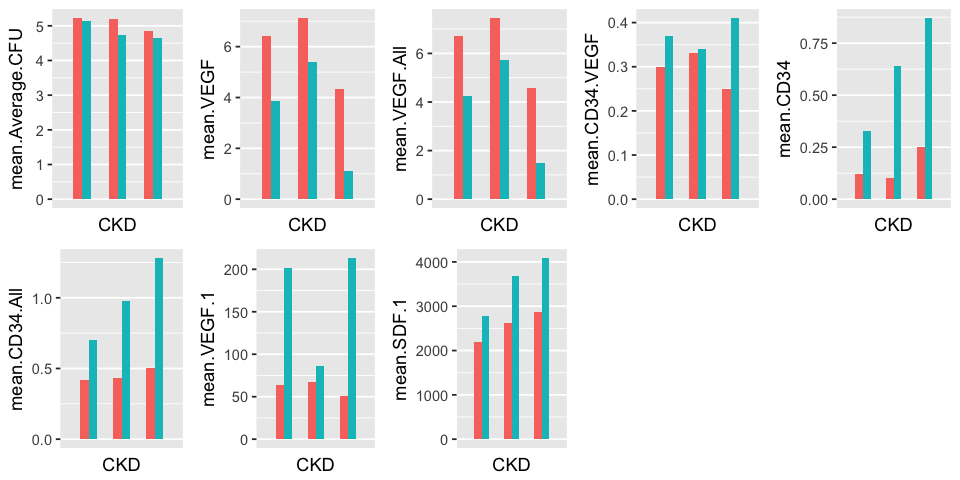

In [43]:
library(gridExtra)
library(repr)
plots <- list()  # new empty list

lab.data <- data %>% 
    group_by( CKD, CLI ) %>% 
    summarise( mean.Average.CFU = mean(Average.CFU, na.rm = T),
            mean.VEGF = mean(VEGF, na.rm = T),
            mean.CD34.VEGF = mean(CD34.VEGF, na.rm=T),
            mean.CD34 = mean(CD34, na.rm = T),
            mean.VEGF.All = mean(VEGF.All, na.rm = T),
            mean.CD34.All = mean(CD34.All, na.rm = T),
            mean.VEGF.1 = mean(VEGF.1, na.rm = T),
            mean.SDF.1 = mean(SDF.1, na.rm = T)
             ) %>%
    mutate_if(is.numeric, funs(round(., 2)))

for (key in c("mean.Average.CFU", "mean.VEGF", "mean.VEGF.All", "mean.CD34.VEGF", "mean.CD34","mean.CD34.All","mean.VEGF.1","mean.SDF.1")) {
    p <- lab.data %>% mutate(CLI = as.factor(CLI)) %>% 
        ggplot(aes_string(x="CKD", y=key, fill="CLI")) +
        geom_bar(stat="identity", position="dodge", width=0.5) +
        scale_x_discrete("CKD", breaks= c(0,1,2), labels = c("0","1", "2")) +
        guides(fill=FALSE)
    plots[[key]] <- p  # add each plot into plot list
}

options(repr.plot.width=8, repr.plot.height=4)
cat("\n\n<CLI 그룹에 따른 Demographic data 시각화>\n")
cat("\n   CLI 0 = 빨강\n")
grid.arrange(grobs=plots, ncol=5)

몇몇 경향성들이 보이는 것 같기도 하다. 



<Lab data 분포 그래프>
   CLI 0 = 빨강


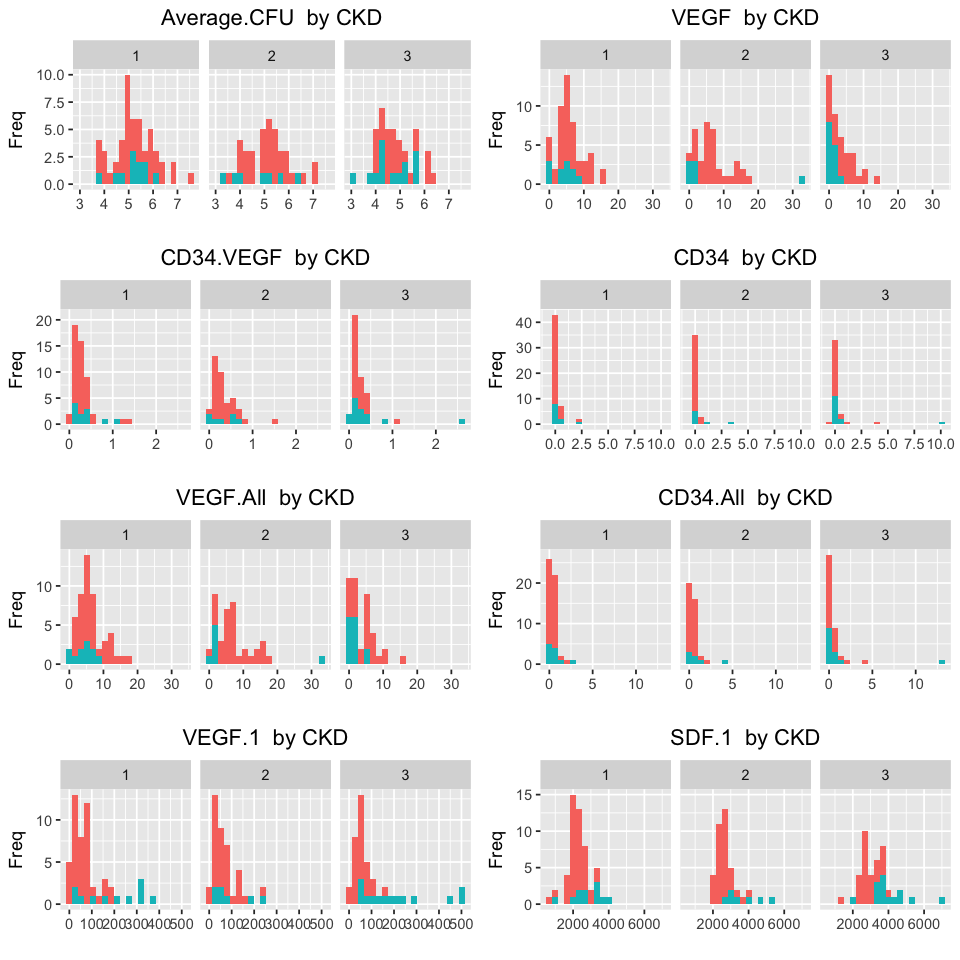

In [104]:
plots <- list() 

# p <- data %>% mutate(CLI=as.factor(CLI), CKD = as.factor(CKD)) %>% 
#     ggplot(aes(x=VEGF, fill=CLI)) +
#     geom_histogram(bins=20, na.rm = T) +  
#     ggtitle("VEGF in CLI by CKD") +
#     labs(x="VEGF by CKD", y="Freq") +
#     theme(plot.title = element_text(hjust = 0.5)) +
#     facet_wrap(~CKD) + 
#     guides(fill=FALSE)

cat("\n\n<Lab data 분포 그래프>")
cat("\n   CLI 0 = 빨강\n")
options(repr.plot.width=8, repr.plot.height=8)


for(key in c('Average.CFU', 'VEGF', 'CD34.VEGF', 'CD34', 'VEGF.All', 'CD34.All', 'VEGF.1', 'SDF.1')){

    p<- data %>% mutate(CLI=as.factor(CLI), CKD = as.factor(CKD)) %>% 
        ggplot(aes_string(x=key, fill = "CLI")) +
        geom_histogram(bins=20, na.rm = T) +  
        ggtitle(paste(key, " by CKD"), ) +
        labs(y="Freq", x=" ") +
        theme(plot.title = element_text(hjust = 0.5))+
        facet_wrap(~CKD) + 
        guides(fill=FALSE)
    
    plots[[key]] <- p
}

grid.arrange(grobs=plots, ncol=2)

## Lab data 검정

### CKD 별, CLI 집단의 lab data 차이 검정 

In [106]:
for( i in 1:3){
    tmp <- data %>% filter(CKD==i)  
    cat("\n\n< CKD =",i,">")
    
    for(key in c('Average.CFU', 'VEGF', 'CD34.VEGF', 'CD34', 'VEGF.All', 'CD34.All', 'VEGF.1', 'SDF.1')){
        fm <- as.formula(paste(key,"~ CLI"))
        test <- wilcox.test(fm, data = tmp)
        cat("\n  ", key, "result : p-value =", round(test$p.value, 4))
    }
}




< CKD = 1 >
   Average.CFU result : p-value = 0.9296
   VEGF result : p-value = 0.056

Warning message in wilcox.test.default(x = c(0.19, 0.1645, 0.1715, 0.174, 0.469, :
“cannot compute exact p-value with ties”


   CD34.VEGF result : p-value = 0.6063
   CD34 result : p-value = 0.4253
   VEGF.All result : p-value = 0.0845
   CD34.All result : p-value = 0.3403
   VEGF.1 result : p-value = 0.0013
   SDF.1 result : p-value = 0.0092

< CKD = 2 >
   Average.CFU result : p-value = 0.3443
   VEGF result : p-value = 0.0063

Warning message in wilcox.test.default(x = c(0.3565, 1.457, 0.2675, 0.7475, 0.1375, :
“cannot compute exact p-value with ties”


   CD34.VEGF result : p-value = 0.9716
   CD34 result : p-value = 0.4213
   VEGF.All result : p-value = 0.0092
   CD34.All result : p-value = 0.6505
   VEGF.1 result : p-value = 0.9445
   SDF.1 result : p-value = 6e-04

< CKD = 3 >
   Average.CFU result : p-value = 0.5774
   VEGF result : p-value = 6e-04

Warning message in wilcox.test.default(x = c(1.091, 0.1755, 0.247, 0.1705, 0.1475, :
“cannot compute exact p-value with ties”


   CD34.VEGF result : p-value = 0.9671

Warning message in wilcox.test.default(x = c(1.111, -0.0145, -0.0145, 0.0835, -0.005, :
“cannot compute exact p-value with ties”


   CD34 result : p-value = 0.1413
   VEGF.All result : p-value = 0.0016
   CD34.All result : p-value = 0.8599
   VEGF.1 result : p-value = 0
   SDF.1 result : p-value = 1e-04

### Lab 결과 

거의 비슷한 결과 이다. 
- VEGF
- VEGF.All
- VEGF.1
- SDF.1 

정도가 유의미하게 보인다. 
CKD 가 높아질수록 유의성이 커지는 것 같은 결과가 보인다. 

## 교란변수 고정

교란 변수를 고정하면 샘플의 수가 너무 작아져서 

분석에 어려움이 있다. (아래 결과 확인) 하지만 적절한 경우 몇가지에 대해서만 분석 해보자

In [120]:
data %>% 
    mutate(CLI = as.factor(CLI), CKD=as.factor(CKD)) %>% 
    group_by(CKD, DM) %>% 
    summarise( CLI0=sum(CLI==0), CLI1=sum(CLI==1) )

data %>% 
    mutate(CLI = as.factor(CLI), CKD=as.factor(CKD)) %>% 
    group_by(CKD, HTN) %>% 
    summarise( CLI0=sum(CLI==0), CLI1=sum(CLI==1) )

data %>% 
    mutate(CLI = as.factor(CLI), CKD=as.factor(CKD)) %>% 
    group_by(CKD, DM, HTN) %>% 
    summarise( CLI0=sum(CLI==0), CLI1=sum(CLI==1) )

CKD,DM,CLI0,CLI1
1,0,25,1
1,1,16,10
2,0,20,1
2,1,13,6
3,0,17,0
3,1,10,14


CKD,HTN,CLI0,CLI1
1,0,3,2
1,1,38,9
2,0,2,3
2,1,31,4
3,0,3,4
3,1,24,10


CKD,DM,HTN,CLI0,CLI1
1,0,0,2,1
1,0,1,23,0
1,1,0,1,1
1,1,1,15,9
2,0,0,1,1
2,0,1,19,0
2,1,0,1,2
2,1,1,12,4
3,0,0,3,0
3,0,1,14,0


#### CKD = 1, DM = 1

In [115]:
tmp <- data %>% filter(CKD==1, DM==1)  
cat("\n\n< CKD = 1, DM = 1>")

for(key in c('Average.CFU', 'VEGF', 'CD34.VEGF', 'CD34', 'VEGF.All', 'CD34.All', 'VEGF.1', 'SDF.1')){
    fm <- as.formula(paste(key,"~ CLI"))
    test <- wilcox.test(fm, data = tmp)
    cat("\n  ", key, "result : p-value =", round(test$p.value, 4))
}




< CKD = 1, DM = 1>
   Average.CFU result : p-value = 0.2005
   VEGF result : p-value = 0.2199
   CD34.VEGF result : p-value = 0.5512
   CD34 result : p-value = 0.421
   VEGF.All result : p-value = 0.2625
   CD34.All result : p-value = 0.3914
   VEGF.1 result : p-value = 0.0169
   SDF.1 result : p-value = 0.0974

#### CKD = 3, DM = 1

In [124]:
tmp <- data %>% filter(CKD==3, DM==1)  
cat("\n\n< CKD = 3, DM = 1>")

for(key in c('Average.CFU', 'VEGF', 'CD34.VEGF', 'CD34', 'VEGF.All', 'CD34.All', 'VEGF.1', 'SDF.1')){
    fm <- as.formula(paste(key,"~ CLI"))
    test <- wilcox.test(fm, data = tmp)
    cat("\n  ", key, "result : p-value =", round(test$p.value, 4))
}




< CKD = 3, DM = 1>
   Average.CFU result : p-value = 0.6665
   VEGF result : p-value = 0.026
   CD34.VEGF result : p-value = 0.8859
   CD34 result : p-value = 0.9771
   VEGF.All result : p-value = 0.0559
   CD34.All result : p-value = 0.508
   VEGF.1 result : p-value = 0
   SDF.1 result : p-value = 4e-04

#### CKD = 1, HTN = 1

In [121]:
tmp <- data %>% filter(CKD==1, HTN==1)  
cat("\n\n< CKD = 1, HTN = 1>")

for(key in c('Average.CFU', 'VEGF', 'CD34.VEGF', 'CD34', 'VEGF.All', 'CD34.All', 'VEGF.1', 'SDF.1')){
    fm <- as.formula(paste(key,"~ CLI"))
    test <- wilcox.test(fm, data = tmp)
    cat("\n  ", key, "result : p-value =", round(test$p.value, 4))
}




< CKD = 1, HTN = 1>
   Average.CFU result : p-value = 0.8421
   VEGF result : p-value = 0.0969

Warning message in wilcox.test.default(x = c(0.19, 0.1645, 0.174, 0.469, 0.188, :
“cannot compute exact p-value with ties”


   CD34.VEGF result : p-value = 0.695
   CD34 result : p-value = 0.7599
   VEGF.All result : p-value = 0.1353
   CD34.All result : p-value = 0.7599
   VEGF.1 result : p-value = 4e-04
   SDF.1 result : p-value = 0.0257

#### CKD = 3, HTN = 1

In [126]:
tmp <- data %>% filter(CKD==3, HTN==1)  
cat("\n\n< CKD = 3, HTN = 1>")

for(key in c('Average.CFU', 'VEGF', 'CD34.VEGF', 'CD34', 'VEGF.All', 'CD34.All', 'VEGF.1', 'SDF.1')){
    fm <- as.formula(paste(key,"~ CLI"))
    test <- wilcox.test(fm, data = tmp)
    cat("\n  ", key, "result : p-value =", round(test$p.value, 4))
}




< CKD = 3, HTN = 1>
   Average.CFU result : p-value = 0.1705
   VEGF result : p-value = 0.0023

Warning message in wilcox.test.default(x = c(0.1755, 0.247, 0.1705, 0.1475, 0.2065, :
“cannot compute exact p-value with ties”


   CD34.VEGF result : p-value = 0.5328

Warning message in wilcox.test.default(x = c(-0.0145, -0.0145, 0.0835, -0.005, -0.013, :
“cannot compute exact p-value with ties”


   CD34 result : p-value = 0.1167
   VEGF.All result : p-value = 0.0047
   CD34.All result : p-value = 0.926
   VEGF.1 result : p-value = 0
   SDF.1 result : p-value = 0.0013

### 고정 결과

대부분 상황에서 VEGF.1 과 SDF.1 이 유의함을 볼 수 있다. 

간혹 VEGF, VEGF.All 도 가끔 유의미

---
# 로지스틱 회귀
---

CKD 도 하나의 변수로 넣으면, CKD가 CLI에 미치는 영향을 다른 변수들과 함께 고려할 수 있다. 

In [131]:
tmp <- data %>% mutate(CKD = as.factor(CKD))
model <- glm(CLI ~ DM+statin+HTN+Gender+smoking+obesity + CKD, family = binomial(),data = tmp)
summary(model)


Call:
glm(formula = CLI ~ DM + statin + HTN + Gender + smoking + obesity + 
    CKD, family = binomial(), data = tmp)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6673  -0.2882  -0.0791  -0.0115   3.2295  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.0174     1.2435  -1.622 0.104722    
DM            4.3734     1.1209   3.902 9.55e-05 ***
statin       -3.6380     1.0480  -3.471 0.000518 ***
HTN          -3.7492     1.2973  -2.890 0.003853 ** 
Gender        2.6062     0.9134   2.853 0.004328 ** 
smoking      -2.5637     0.8940  -2.868 0.004133 ** 
obesity       2.0537     0.8827   2.327 0.019988 *  
CKD2         -0.2207     0.9187  -0.240 0.810192    
CKD3          1.0196     0.8409   1.213 0.225278    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 146.771  on 132  degrees of freedom
Residual deviance:  56.905  on 124  degre

In [134]:
tmp <- data %>% mutate(CKD = as.factor(CKD))
model <- glm(CLI ~ DM+statin+HTN+Gender+smoking+obesity + CKD + log(SDF.1) + log(VEGF) + VEGF.1, family = binomial(),data = tmp)
summary(model)



Call:
glm(formula = CLI ~ DM + statin + HTN + Gender + smoking + obesity + 
    CKD + log(SDF.1) + log(VEGF) + VEGF.1, family = binomial(), 
    data = tmp)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.53620  -0.06516  -0.00492  -0.00015   2.81606  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)   
(Intercept) -48.96716   23.61048  -2.074  0.03808 * 
DM            6.31927    2.19265   2.882  0.00395 **
statin       -3.42996    1.59306  -2.153  0.03131 * 
HTN          -2.61905    1.92707  -1.359  0.17412   
Gender        5.40451    2.54013   2.128  0.03337 * 
smoking      -4.66078    1.98350  -2.350  0.01878 * 
obesity       4.29511    1.83073   2.346  0.01897 * 
CKD2         -0.14212    1.78720  -0.080  0.93662   
CKD3         -1.45100    2.11255  -0.687  0.49218   
log(SDF.1)    5.22038    2.75944   1.892  0.05851 . 
log(VEGF)    -1.81558    0.83189  -2.182  0.02908 * 
VEGF.1        0.03244    0.01504   2.157  0.03103 * 
---
Signif. co

In [133]:
library(leaps)
tmp <- data %>% mutate(CKD = as.factor(CKD))
b <- regsubsets(CLI ~ DM+statin+Gender+smoking+obesity + log(SDF.1) + log(VEGF) + VEGF.1 + CKD , data=tmp, nvmax = 20)
summary(b)


Subset selection object
Call: regsubsets.formula(CLI ~ DM + statin + Gender + smoking + obesity + 
    log(SDF.1) + log(VEGF) + VEGF.1 + CKD, data = tmp, nvmax = 20)
10 Variables  (and intercept)
           Forced in Forced out
DM             FALSE      FALSE
statin         FALSE      FALSE
Gender         FALSE      FALSE
smoking        FALSE      FALSE
obesity        FALSE      FALSE
log(SDF.1)     FALSE      FALSE
log(VEGF)      FALSE      FALSE
VEGF.1         FALSE      FALSE
CKD2           FALSE      FALSE
CKD3           FALSE      FALSE
1 subsets of each size up to 10
Selection Algorithm: exhaustive
          DM  statin Gender smoking obesity log(SDF.1) log(VEGF) VEGF.1 CKD2
1  ( 1 )  " " " "    " "    " "     " "     " "        " "       "*"    " " 
2  ( 1 )  " " " "    " "    " "     " "     " "        "*"       "*"    " " 
3  ( 1 )  "*" " "    " "    " "     " "     " "        "*"       "*"    " " 
4  ( 1 )  "*" "*"    " "    " "     " "     " "        "*"       "*"    " " 
5  

### 회귀 결과
딱히 CKD 가 CLI나 다른 변수들에 미치는 영향이 두드러지지는 않는 것으로 보인다. 